# Homework 1

## Task 2

### Import Text Adventures

In [1]:
from text_adventure_games import (
    games, parsing, actions, things, blocks, viz
)

## Locations

In [2]:

home = things.Location(
    "Home",
    "You are standing in your home."
)
winding_path = things.Location(
    "Winding Path",
    "You are walking along a winding path towards the fishing pond.",
)
fishing_pond = things.Location(
    "Fishing Pond",
    "You are at the edge of a small fishing pond."
)
thorny_path = things.Location(
    "Thorny Path",
    "You are walking along an abandoned thorny path towards an abandoned house.",
)
abandoned_house = things.Location(
    "Abandoned House",
    "You are at the abandoned house. It hasn't been used for a long time."
)
kitchen = things.Location(
    "Kitchen",
    "You are in the kitchen of the abandoned house."
)
garden_path = things.Location(
    "Garden Path",
    "You are walking along a garden path.",
)
den = things.Location(
    "Den",
    "You are in a lion's den. The lion is hungry and is going to attack you."
)
death = things.Location(
    "The Afterlife",
    "You lost. GAME OVER."
)
death.set_property("game_over", True)


# Map of Locations
home.add_connection("out", winding_path)
winding_path.add_connection("south", fishing_pond)
fishing_pond.add_connection("east", thorny_path)
thorny_path.add_connection("east", abandoned_house)
abandoned_house.add_connection("in", kitchen)
fishing_pond.add_connection("south", garden_path)
garden_path.add_connection("south", den)

###  Preliminary Game Map

Here is a visualization of the locations in action castle represented as a directed graph.

![Visualization of game map starting from the tower](../map-from-tower.svg)

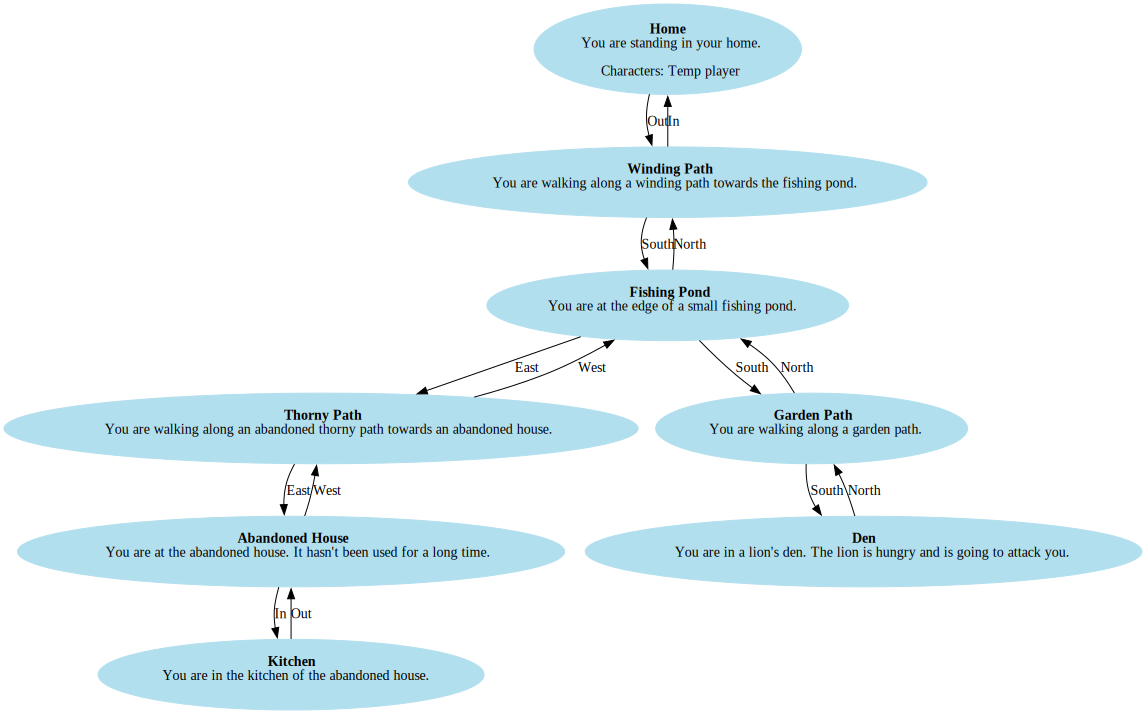

In [3]:
tempgame = games.Game(home, things.Character(name="Temp Player", description="", persona=""))

from text_adventure_games.viz import Visualizer
viz = Visualizer(tempgame)
graph = viz.visualize()
graph

## Items

### Gettable Items

In [4]:
# Put a fishing pole at the home
fishing_pole = things.Item(
    "pole",
    "a fishing pole",
    "A SIMPLE FISHING POLE.",
)
home.add_item(fishing_pole)


# Put a knife in the abandoned house that could be used as a weapon
knife = things.Item(
    "knife",
    "a sharp knife",
    "IT LOOKS LIKE IT WOULD MAKE A GOOD WEAPON.",
)
knife.set_property("is_weapon", True)
kitchen.add_item(knife)


#There is a key on the path
key = things.Item(
    "key", 
    "a brass key", 
    "THIS LOOKS USEFUL"
)
thorny_path.add_item(key)


### Scenery Items

_We called these "non-gettable" in the tutorial_

In [5]:
# Put an actual pond at the fishing location
pond = things.Item(
    "pond",
    "a small fishing pond",
    "THERE ARE FISH IN THE POND.",
)
pond.set_property("gettable", False)
pond.set_property("has_fish", True)
pond.add_command_hint("catch fish with pole")
fishing_pond.add_item(pond)

# A door that leads to the abandoned house
door = things.Item(
    "door",
    "a door",
    "THE DOOR IS SECURELY LOCKED."
)
door.set_property("gettable", False)
door.set_property("is_locked", True)
door.add_command_hint("unlock door")
abandoned_house.add_item(door)

## Characters

### Player

In [6]:
# Player
player = things.Character(
    name="The player",
    description="You are a simple peasant destined for greatness.",
    persona="I am on an adventure.",
)
player.set_property("is_reigning", False)
player.set_property("is_strong", False)

### Non-Player Characters (NPCs)

In [7]:
# A lion in the den
lion = things.Character(
    name="lion",
    description="A lion",
    persona="I am hungry and will kill anyone who approaches me.",
)
lion.set_property("is_hungry", True)
lion.set_property("is_dead", False)
lion.set_property("character_type", "lion")
den.add_character(lion)

## Actions

In [8]:
from text_adventure_games.actions import base
from text_adventure_games.actions import preconditions as P
from text_adventure_games.things import Item

In [9]:
class Hunt_Fish(base.Action):
    ACTION_NAME = "catch fish"
    ACTION_DESCRIPTION = "Catch fish with a pole"
    ACTION_ALIASES = ["go fishing"]

    def __init__(self, game, command: str):
        super().__init__(game)
        self.character = self.parser.get_character(command)
        self.pond = self.character.location
        self.pole = self.parser.match_item("pole", self.parser.get_items_in_scope(self.character))
        
        if not " with pole" in command:
            self.character.set_property("is_dead", True)
            description= " The character reaches into the pond and tries to catch a fish with their hands, but there are alligators who are hungry. GAME OVER"
            self.parser.fail(description)
        elif not self.pole:
            description= "Character doesn't have a pole in their inventory! "
            self.parser.fail(description )
        else:
            fish = Item("fish", "a dead fish", "IT SMELLS TERRIBLE.")
            fish.add_command_hint("eat fish")
            fish.set_property("is_food", True)
            fish.set_property(
                "taste", "disgusting! It's raw! And definitely not sashimi-grade!"
            )
            self.pond.set_property("has_fish", True)
            self.pond.add_item(fish)

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * There must be a pond
        * The character must be at the pond
        * The character must have a fishing pole in their inventory
        """
    
        if not self.pole:
            return False
        if not self.was_matched(self.pond, "There's no pond here."):
            return False
        if not self.pond.get_property("has_fish"):
            description= "The pond has no fish."
            self.parser.fail(description)
            return False
        return True

    def apply_effects(self):
        """
        Effects:
        * Creates a new item for the fish
        * Adds the fish to the character's inventory
        * Sets the 'has_fish' property of the pond to False.
        """
        if not self.pole:
            return 

        fish = self.pond.get_item("fish")
        if fish:
            self.pond.set_property("has_fish", False)
            self.pond.remove_item(fish)
            self.character.add_to_inventory(fish)
    
        description = "Character dips their hook into the pond, catches a fish and eats it."
        self.parser.ok(description)
        self.character.set_property("is_strong", True)


In [10]:
class Attack_Lion(base.Action):
    ACTION_NAME = "attack"
    ACTION_DESCRIPTION = "Attack someone with a weapon"
    ACTION_ALIASES = ["kill"]

    def __init__(
        self,
        game,
        command: str
    ):
        super().__init__(game)
        self.character = self.parser.get_character("")
        self.lion = self.parser.get_character(command)
        self.knife= self.parser.match_item("knife", self.parser.get_items_in_scope(self.character))
        
    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * There must be a lion
        * They must be in the same location
        * The character should have a knife in their inventory
        """
    
        if not self.lion:
            description = "There is no lion."
            self.parser.fail(description)
            return False
        
        if not self.character.location.here(self.lion):
            description = "You are not in the same location as the lion."
            self.parser.fail(description)
            return False
        
        if not self.knife:
            description = "Character doesn't have a knife."
            self.parser.fail(description)
            return False

        return True

    def apply_effects(self):
        """
        Effects:
        * If the character has a knife, the lion is killed.
        * If the character doesn't have a knife, the character dies.
        """
        if self.knife and self.character.get_property("is_strong"):
            description = "You attacked the lion with the knife and killed it!".format(
                attacker=self.character
            )
            self.parser.ok(description)
            self.lion.set_property("is_dead", True)
            self.character.set_property("is_reigning", True)
        
        elif not self.character.get_property("is_strong"):
            description = (
                "You didn't have enough strength to defeat the lion. You should have had some food.".format(
                    attacker=self.character
                )
            )
            self.parser.fail(description)
            self.character.set_property("is_dead", True)
        else:
            description = (
                "You tried to attack the lion without a knife and was killed.".format(
                    attacker=self.character
                )
            )
            self.parser.fail(description)
            self.character.set_property("is_dead", True)


In [11]:
class Unlock(actions.Action):
    ACTION_NAME = "unlock"
    ACTION_DESCRIPTION = "Unlock a door with a key"
    ACTION_ALIASES = []
    
    def __init__(self, game, command):
        super().__init__(game)
        # TODO - your code here
        self.command = command
        self.character = self.parser.get_character(command)
        self.key = self.parser.match_item("key", self.parser.get_items_in_scope(self.character))
        self.door = self.parser.match_item("door", self.parser.get_items_in_scope(self.character))
        # HINT: take a look at text_adventures/actions for some examples of actions!

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * There must be a door
        * The character must be at the same location as the door 
        * The door must be locked
        * The character must have the key in their inventory
        """
        if not self.door:
            description= "There is no door here."
            self.parser.fail(description)
            return False
        if not self.door.get_property("is_locked"):
            description= "The door is not locked."
            self.parser.fail(description)
            return False
        if not self.key:
            description= "You do not have a key."
            self.parser.fail(description)
            return False
        return True

    def apply_effects(self):
        """
        Effects:
        * Unlocks the door
        """
        self.door.set_property("is_locked", False)
        description="Door is unlocked"
        self.parser.ok(description)

## Blocks

In [12]:
class Door_Block(blocks.Block):
    """
    Blocks progress in this direction until the character unlocks the door.
    """

    def __init__(self, location: things.Location, door: things.Item):
        super().__init__("A locked door blocks your way", "The door ahead is locked.")
        # TODO - your code here
        self.location = location
        self.door = door

    def is_blocked(self) -> bool:
        # Conditions of block:
        # * The door is locked
        # TODO - your code here
        if self.door.get_property("is_locked"):
            return True

In [13]:
door_block = Door_Block(abandoned_house, door)
abandoned_house.add_block("in", door_block)

## Play Action Den

In [14]:
class ActionDen(games.Game):
    def __init__(
        self, start_at: things.Location, player: things.Character, characters=None,
        custom_actions=None
    ):
        super().__init__(start_at, player, characters=characters, custom_actions=custom_actions)

    def is_won(self) -> bool:
        """ 
        Checks whether the game has been won. For Action Den, the game is won
        once any character has defeated the Lion (has the property is_reigning).
        """
        for name, character in self.characters.items():
            if character.get_property("is_reigning"):
                msg = "{name} has now defeated the KING OF JUNGLE and conquered the Action Den! {name} has won the game!"
                self.parser.ok(msg.format(name=character.name.title()))
                return True
        return False

In [15]:

characters = [lion]
custom_actions = [Hunt_Fish, Unlock, Attack_Lion]

# The Game
game = ActionDen(home, player, characters=characters, custom_actions=custom_actions)


In [16]:
game.game_loop()

You are standing in your home.
Exits:
Out to Winding Path

You see:
 * a fishing pole
Characters:
 *

The player got the pole.
You are walking along a winding path towards the fishing pond.
Exits:
In to Home
South to Fishing Pond




You are at the edge of a small fishing pond.
Exits:
North to Winding Path
East to Thorny Path
South to Garden Path

You see:
 * a small fishing pond
        catch fish with pole


Character dips their hook into the pond, catches a fish and eats it.
You are walking along an abandoned thorny path towards an abandoned house.
Exits:
West to Fishing Pond
East to Abandoned House

You see:
 * a brass key


The player got the key.
You are at the abandoned house. It hasn't been used for a long time.
Exits:
West to Thorny Path
In to Kitchen

You see:
 * a door
        unlock door


Door is unlocked
You are in the kitchen of the abandoned house.
Exits:
Out to Abandoned House

You see:
 * a sharp knife


The player got the knife.
You are at the abandoned house. It has